In [29]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import configparser
import json


import modules.load_data as ld
from modules.modules_FIG_08_10_11 import *

config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

ECRAD = xr.open_dataset(os.path.join(pf,"TCARS.nc"))
# bias correction see FIG5 
ECRAD.REari_sfc.values = ECRAD.REari_sfc.values+1.5
ECRAD.REari_toa.values = ECRAD.REari_toa.values-0.6

stations= ld.dwd_stations()
stations = stations.where(stations.station!='ZG',drop=True)


models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])


models_label = np.array([
                         'MRM v6.1',
                         'ESRA',
                         'Heliosat-1',
                         'Solis simple',
                         'CEM',
                         'MMAC',
                         'METSTAT',
 
                        ])

models_aodwvl = np.array([
                           550,
                           550,
                           550,
                           700,
                           0,
                           0,
                           0,
                          ])

fname_CAMS_AOD = os.path.join(pf,"TCARS_CSF_AOD_2015.nc")
dsAOD = xr.open_dataset(fname_CAMS_AOD)

fname_AERONET = os.path.join(pf,'aeronet_sites.json')
path_AERONET = os.path.join(pf,'AERONET/')

with open(fname_AERONET) as txt:
    sites=json.load(txt)  
    
Aaod_AOD_KEY = 'AOD_500nm'



In [30]:
import cartopy.crs as ccrs
def make_plot1(fig,ax,x,y,data,data2=None,title='',
              clabel='',cmap='autumn_r',cborientation='vertical',cbaxextend=[],
              cbpanchor=False,cbspacing='proportional',
              cb=True,cbarres=2,cbticks=None,cbaspect=20,
              data2res=2,data2ticks=None):
    # make subplot

    ax.set_title(title,fontsize=14)
    
    # plot map
    fig,ax = make_map(fig,ax)
   
    if type(cbticks)==type(None):
        # make contourplot
        ticks = np.arange(np.round(np.nanpercentile(data,1),cbarres)-10**(-cbarres),
                          np.round(np.nanpercentile(data,99),cbarres)+10**(-cbarres),10**(-cbarres))
        while len(ticks)>11:
            ticks = ticks[::2]
    else:
        ticks=cbticks
    p1=ax.contourf(x,y,data,transform=ccrs.PlateCarree(),cmap=cmap,vmin=np.min(ticks),vmax=np.max(ticks),
                   levels = ticks)
    
    if type(data2)!=type(None):
        if type(data2ticks)==type(None):
            # make contourplot
            ticks2 = np.arange(np.round(np.nanpercentile(data2,1),data2res),
                               np.round(np.nanpercentile(data2,99),data2res),10**(-data2res))
            while len(ticks2)>11:
                ticks2 = ticks2[::2]
        else:
            ticks2=data2ticks
        
        CS=ax.contour(x,y,data2,transform=ccrs.PlateCarree(),levels=ticks2,colors=['k']*len(ticks2))
        ax.clabel(CS, inline=1, fontsize=14)
    
    if cb:
        cbaxes = ax
        if len(cbaxextend)>0:
            cbaxes = [ax]+cbaxextend
        if type(cbpanchor)==type(bool):
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9,
                              label = ' ')
        else:
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              panchor=cbpanchor,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9,
                              label = ' ')
        cb.ax.set_title(clabel,loc='left')
    fig.canvas.draw()
    return fig, ax

# Figs 8,10,11
These figures show the annual mean of the aerosol situation, radiation budget and REari over Germany.

In [31]:
# annual mean
AODyear = dsAOD.sel(model='ESRA')
AODyear = AODyear.interpolate_na(dim='day')
AODyear = AODyear.assign({'latitude':('station',stations.latitude),
                          'longitude':('station',stations.longitude)})



Eseas = ECRAD.groupby('day.season').mean(skipna=True)
AODseas = AODyear.groupby('day.season').mean(skipna=True)

for seas in ['DJF','MAM','JJA','SON']:
    globals()[f"E{seas}"] = Eseas.sel(season=seas)
    globals()[f"AOD{seas}"] = AODseas.sel(season=seas)

Eyear = ECRAD.mean(dim='day',skipna=True)# where(~np.isnan(AODyear.CAOD.values))
AODyear = AODyear.mean(dim='day',skipna=True)


aodsyear,lons,lats=[],[],[]
for seas in ['DJF','MAM','JJA','SON']:
        globals()[f"aods{seas}"] = []
for site in sites.keys():  
    Aaod20,_ = ld.load_aeronet(site,pf=path_AERONET)
    if type(Aaod20)==bool:
        continue
    ds = xr.Dataset.from_dataframe(Aaod20).swap_dims({'index':'time'})
    try:
        aod = ds.AOD_500nm.sel(time='2015').resample(time='1D').mean(skipna=True)
        aod = aod.rename({'time':'day'}).reindex_like(AODyear).interpolate_na(dim='day')
        aodyear = aod.mean(skipna=True)
        aodseas = aod.groupby('day.season').mean(skipna=True)
        aodyear = float(aodyear)
        for seas in aodseas.season.values:
            globals()[f"aod{seas}"] = float(aodseas.sel(season=seas).values)
    except:
        continue
    lat = sites[site]['position']['latitude']
    lon = sites[site]['position']['longitude']

    aodsyear.append(aodyear)
    for seas in ['DJF','MAM','JJA','SON']:
        globals()[f"aods{seas}"].append(globals()[f"aod{seas}"])
    lats.append(lat)
    lons.append(lon)

In [10]:
Aaod20,_ = ld.load_aeronet('Leipzig',pf=path_AERONET)
ds = xr.Dataset.from_dataframe(Aaod20).swap_dims({'index':'time'})

In [14]:

aod = ds.AOD_500nm.sel(time='2015').resample(time='1D').mean(skipna=True)
aod = aod.rename({'time':'day'}).reindex_like(AODyear).interpolate_na(dim='day')
aod.groupby('day.season').mean(skipna=True)

<xarray.DataArray 'AOD_500nm' (season: 4)>
array([0.12803244, 0.2333031 , 0.19103335, 0.12261858])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [5]:
ECRAD.groupby('day.season').mean(skipna=True)

<xarray.Dataset>
Dimensions:            (lat: 14, lon: 14, season: 4)
Coordinates:
  * lat                (lat) float64 46.0 46.75 47.5 48.25 ... 54.25 55.0 55.75
  * lon                (lon) float64 5.5 6.25 7.0 7.75 ... 13.0 13.75 14.5 15.25
  * season             (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/27)
    GLO                (season, lat, lon) float64 103.4 106.7 ... 114.7 114.7
    DIR                (season, lat, lon) float64 85.27 89.96 ... 93.47 93.6
    GLO0               (season, lat, lon) float64 107.6 110.1 ... 120.8 120.8
    DIR0               (season, lat, lon) float64 93.85 96.9 ... 105.6 105.6
    REari_sfc          (season, lat, lon) float64 -2.334 -1.642 ... -4.526
    REari_toa          (season, lat, lon) float64 -3.059 -2.607 ... -4.654
    ...                 ...
    kernel_H2O_sfc     (season, lat, lon) float64 -0.02444 -0.01856 ... -0.05348
    kernel_H2O_toa     (season, lat, lon) float64 -0.02595 -0.01968 ... -0.05474
    kernel_O3_sfc      (season, lat, lon) float64 0.0003778 ... 0.0005594
    kernel_O3_toa      (season, lat, lon) float64 0.00025 0.000192 ... 0.0003478
    kernel_ALBEDO_sfc  (season, lat, lon) float64 0.001206 0.0009855 ... 0.0
    kernel_ALBEDO_toa  (season, lat, lon) float64 0.001474 0.001212 ... 0.0

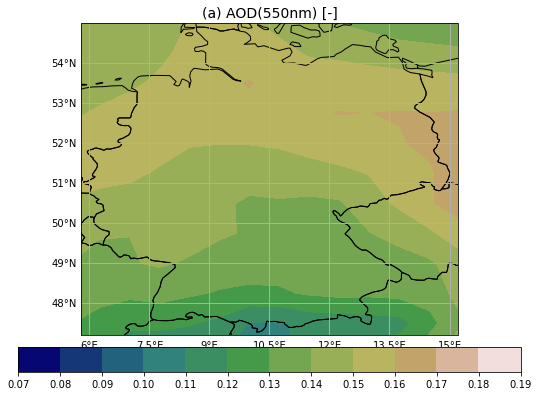

In [100]:
camsra_fname_2015 = os.path.join(pf,'CAMSRA/cams-ra_2015-*_{ftype}.nc')
CAMSsfc = xr.open_mfdataset(camsra_fname_2015.format(ftype='sfc'),combine='by_coords')
CAMSsfc = CAMSsfc.aod550.compute()
CAMSsfc = CAMSsfc.mean(dim=['time'],skipna=True)

fig = plt.figure(figsize=(10,7))

ax = plt.subplot2grid((1,1),(0,0),
                      colspan=1,rowspan=1,
                      projection=ccrs.PlateCarree())
fig,ax = make_plot1(fig,ax,CAMSsfc.lon,CAMSsfc.lat,CAMSsfc..values,
                   cbpanchor=(0.65,0.5),
                   cbticks=np.arange(0.07,0.2,0.01),
                   title='(a) AOD(550nm) [-]',cmap='gist_earth',
                   cborientation='horizontal')

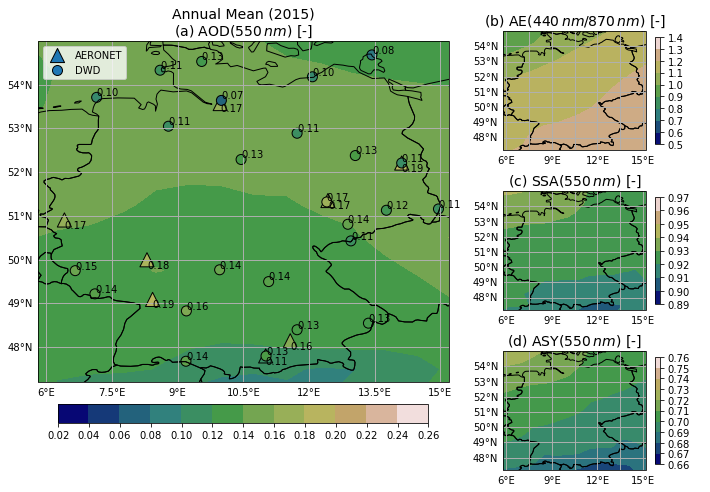

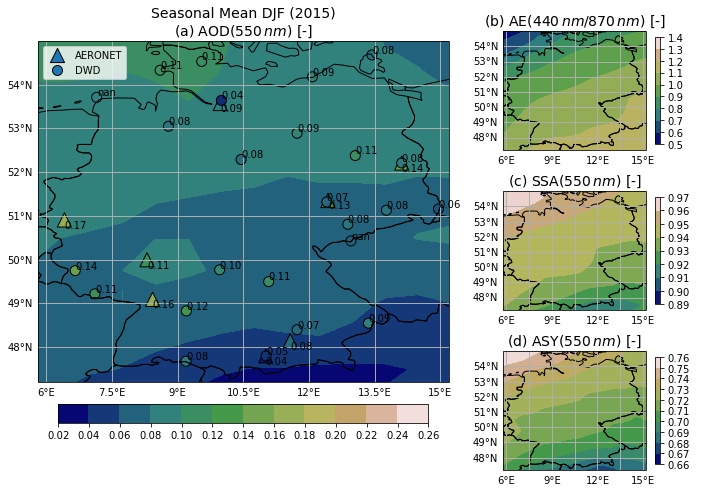

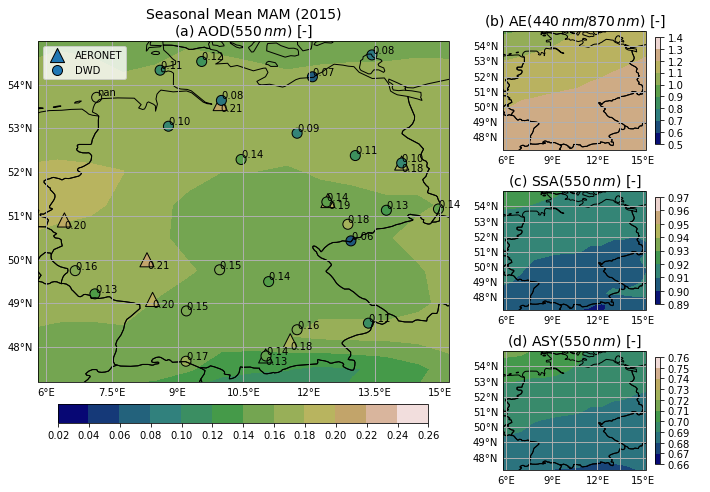

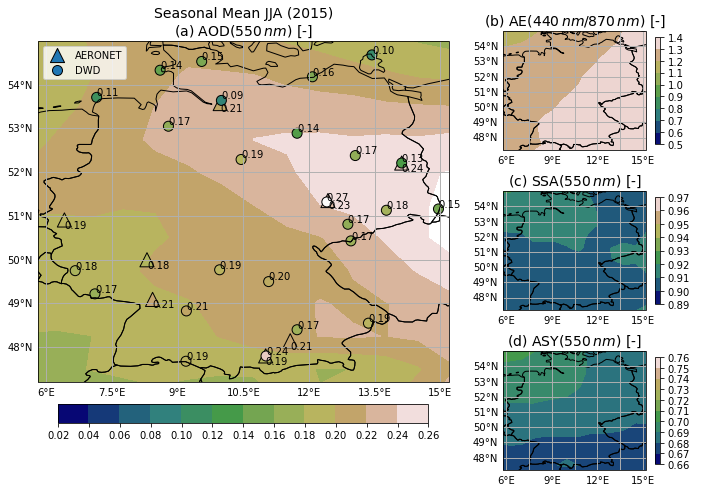

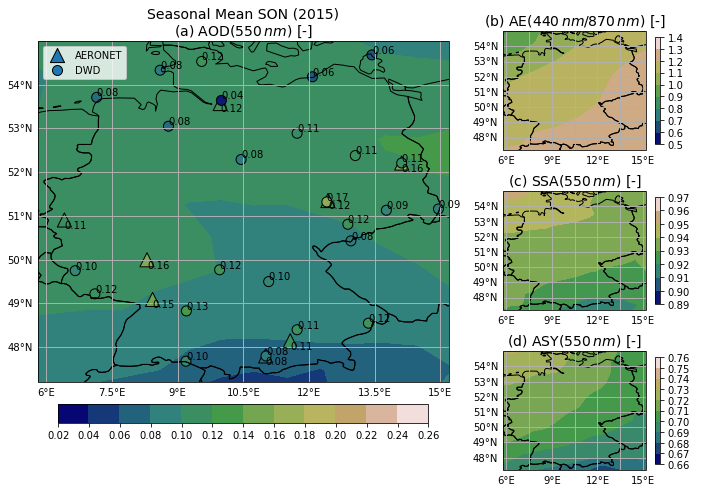

In [26]:
### plot Figurest 8,10,11


for select in ['year','DJF','MAM','JJA','SON']:
    E = globals()[f"E{select}"]
    AOD = globals()[f"AOD{select}"]
    aods = globals()[f"aods{select}"]

    ### aerosol situation

    fig = plt.figure(figsize=(10,7))
    vmin=0.02
    vmax=0.26

    ax = plt.subplot2grid((3,3),(0,0),
                          colspan=2,rowspan=3,
                          projection=ccrs.PlateCarree())
    
    if select == 'year':
        title = "Annual Mean (2015)"
    else:
        title = f"Seasonal Mean {select} (2015)"
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.AOD.values,
                       cbpanchor=(0.5,-0.2),
                       cbticks=np.arange(vmin,vmax+0.02,0.02),
                       title=title+'\n'+r'(a) AOD(550$\,nm$) [-]',cmap='gist_earth',
                       cborientation='horizontal')
    ax.scatter(lons,lats,
               s = 200,
               c = aods,
               vmin=vmin,vmax=vmax,
               cmap='gist_earth',
               edgecolors = 'k',
               marker='^',
              transform=ccrs.PlateCarree(),label='AERONET')  

    ax.scatter(AOD.longitude,AOD.latitude,
               s = 100,
               c = AOD.CAOD.values,
               vmin=vmin,vmax=vmax,
               cmap='gist_earth',
               edgecolors = 'k',
              transform=ccrs.PlateCarree(), label='DWD')
    for station in stations.station.values:
        AODs = AOD.sel(station=station)
        aod = float(AODs.CAOD.values)
        lat = float(AODs.latitude.values)
        lon = float(AODs.longitude.values)
        ax.annotate(f"{aod:.2f}",
                    xy=(lon,lat),
                    va='bottom',
                    transform=ccrs.PlateCarree())

    for lat,lon,aod in zip(lats,lons,aods):
        ax.annotate(f"{aod:.2f}",
                    xy=(lon,lat),
                    va='top',
                    transform=ccrs.PlateCarree())

    plt.legend()

    ax = plt.subplot2grid((3,3),(0,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.AE.values,
                       title=r'(b) AE(440$\,nm$/870$\,nm$) [-]',cmap='gist_earth',cbarres=1,
                        cbticks=np.arange(0.5,1.5,0.1))

    ax = plt.subplot2grid((3,3),(1,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.SSA.values,
                        title=r'(c) SSA(550$\,nm$) [-]',cmap='gist_earth',
                        cbticks=np.arange(0.89,0.98,0.01))

    ax = plt.subplot2grid((3,3),(2,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.G.values,
                        title=r'(d) ASY(550$\,nm$) [-]',cmap='gist_earth',
                        cbticks=np.arange(0.66,0.77,0.01))
    plt.tight_layout()
    plt.savefig(f"figures/Fig08_with_stations_{select}.pdf",dpi=300,bbox_inches='tight')
    plt.savefig(f"figures/Fig08_with_stations_{select}.png",dpi=300,bbox_inches='tight')

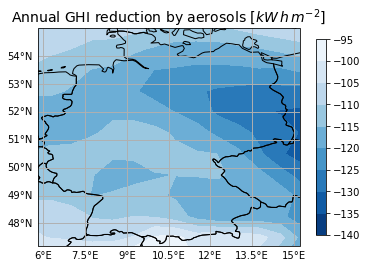

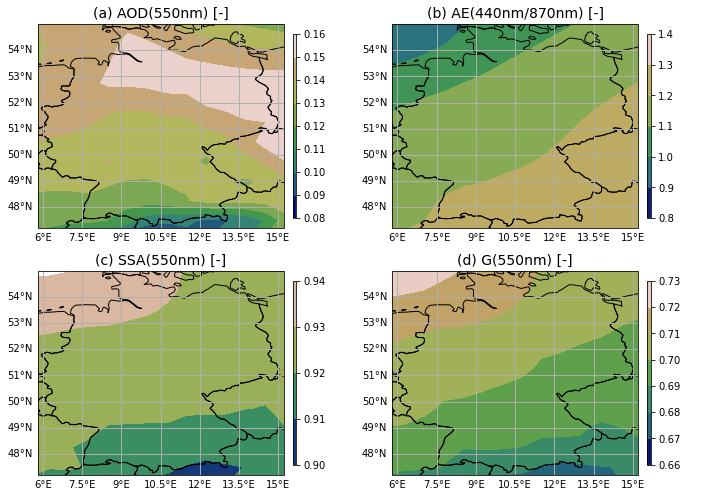

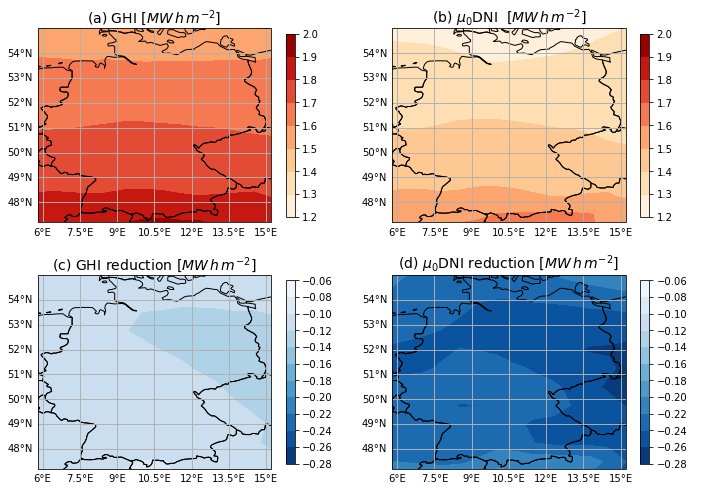

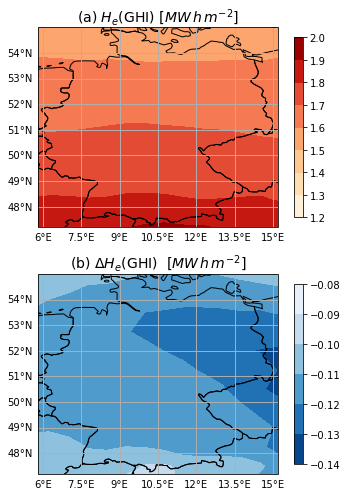

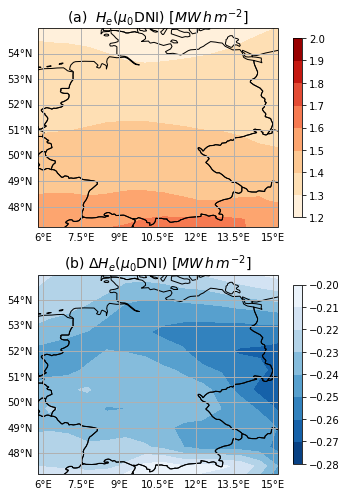

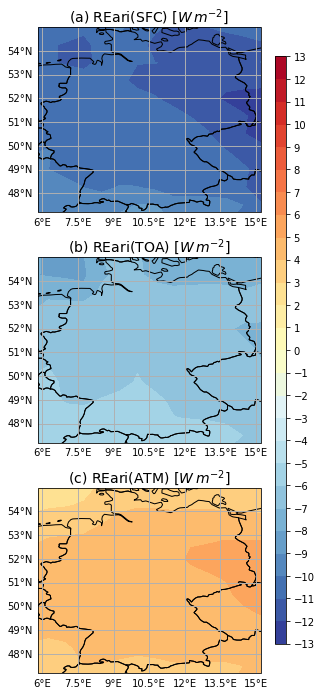

In [45]:
### plot Figurest 8,10,11
# annual mean
Eyear = ECRAD.mean(dim='day')


### aerosol situation
fig = plt.figure(figsize=(10,7))
fig,ax = make_plot(fig,(2,2,1),Eyear.lon,Eyear.lat,Eyear.AOD.values,
                   title='(a) AOD(550nm) [-]',cmap='gist_earth')
fig,ax = make_plot(fig,(2,2,2),Eyear.lon,Eyear.lat,Eyear.AE.values,
                   title='(b) AE(440nm/870nm) [-]',cmap='gist_earth',cbarres=1)
fig,ax = make_plot(fig,(2,2,3),Eyear.lon,Eyear.lat,Eyear.SSA.values,title='(c) SSA(550nm) [-]',cmap='gist_earth')
fig,ax = make_plot(fig,(2,2,4),Eyear.lon,Eyear.lat,Eyear.G.values,title='(d) G(550nm) [-]',cmap='gist_earth')
plt.tight_layout()
plt.savefig("figures/Fig08.pdf",dpi=300,bbox_inches='tight')


### radiation budget overview
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(221,projection=ccrs.PlateCarree())
fig,ax1 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.GLO.values*24.*365*1e-6,cmap='OrRd',#
                   cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(a) GHI [$MW\,h\,m^{-2}$]')
ax = plt.subplot(222,projection=ccrs.PlateCarree())
fig,ax2 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.DIR.values*24.*365*1e-6,cmap='OrRd',
                   cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(b) $\mu_0$DNI  [$MW\,h\,m^{-2}$]')
ax = plt.subplot(223,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.GLO-Eyear.GLO0).values*24.*365*1e-6,cmap='Blues_r',
                   cbticks=np.arange(-0.28,-0.06,0.02),
                   title=r'(c) GHI reduction [$MW\,h\,m^{-2}$]')
ax = plt.subplot(224,projection=ccrs.PlateCarree())
fig,ax4 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.DIR-Eyear.DIR0).values*24.*365*1e-6,cmap='Blues_r',
                    cbticks=np.arange(-0.28,-0.06,0.02),
                   title=r'(d) $\mu_0$DNI reduction [$MW\,h\,m^{-2}$]')

plt.tight_layout()
plt.savefig("figures/Fig10.pdf",dpi=300,bbox_inches='tight')


fig = plt.figure(figsize=(5,7))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
fig,ax1 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.GLO.values*24.*365*1e-6,cmap='OrRd',#
                   cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(a) $H_e$(GHI) [$MW\,h\,m^{-2}$]')
ax = plt.subplot(212,projection=ccrs.PlateCarree())
fig,ax2 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.GLO-Eyear.GLO0).values*24.*365*1e-6,cmap='Blues_r',
                   cbticks=np.arange(-0.14,-0.08,0.01),
                   title=r'(b) ${\Delta}H_e$(GHI)  [$MW\,h\,m^{-2}$]')

plt.tight_layout()
plt.savefig("figures/Fig10_GHI.pdf",dpi=300,bbox_inches='tight')

fig = plt.figure(figsize=(5,7))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.DIR.values*24.*365*1e-6,cmap='OrRd',
                     cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(a)  $H_e$($\mu_0$DNI) [$MW\,h\,m^{-2}$]')
ax = plt.subplot(212,projection=ccrs.PlateCarree())
fig,ax4 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.DIR-Eyear.DIR0).values*24.*365*1e-6,cmap='Blues_r',
                    cbticks=np.arange(-0.28,-0.20,0.01),
                   title=r'(b) ${\Delta}H_e$($\mu_0$DNI) [$MW\,h\,m^{-2}$]')

plt.tight_layout()
plt.savefig("figures/Fig10_DNI.pdf",dpi=300,bbox_inches='tight')


### REari overview
fig = plt.figure(figsize=(5,12))
ax = plt.subplot(311,projection=ccrs.PlateCarree())
fig,ax1 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_sfc,cmap='RdYlBu_r',cb=False,
                   cbticks=np.arange(-13,14,1),
                   title=r'(a) REari(SFC) [$W\,m^{-2}$]')
ax = plt.subplot(312,projection=ccrs.PlateCarree())
fig,ax2 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_toa,cmap='RdYlBu_r',
                   cb=False,
                   cbticks=np.arange(-13,14,1),
                   title=r'(b) REari(TOA) [$W\,m^{-2}$]')
ax = plt.subplot(313,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_toa-Eyear.REari_sfc,
                   cmap='RdYlBu_r',cbaxextend=[ax1,ax2],
#                     cborientation='horizontal',
                    cbpanchor=(0.4,0.5),
                     cbaspect=50,
                   cbticks=np.arange(-13,14,1),
                   title=r'(c) REari(ATM) [$W\,m^{-2}$]')
plt.savefig("figures/Fig11.pdf",dpi=300,bbox_inches='tight')

In [43]:
ECRAD

<xarray.Dataset>
Dimensions:            (day: 365, lat: 14, lon: 14)
Coordinates:
  * day                (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
  * lat                (lat) float64 46.0 46.75 47.5 48.25 ... 54.25 55.0 55.75
  * lon                (lon) float64 5.5 6.25 7.0 7.75 ... 13.0 13.75 14.5 15.25
Data variables: (12/27)
    GLO                (day, lat, lon) float64 76.62 79.64 84.45 ... 31.79 32.07
    DIR                (day, lat, lon) float64 60.39 64.88 72.41 ... 23.46 23.81
    GLO0               (day, lat, lon) float64 81.99 83.71 85.36 ... 33.17 33.3
    DIR0               (day, lat, lon) float64 69.91 72.07 74.12 ... 25.87 25.99
    REari_sfc          (day, lat, lon) float64 -3.397 -2.24 ... 0.1232 0.2707
    REari_toa          (day, lat, lon) float64 -3.143 -2.541 ... -1.544 -1.472
    ...                 ...
    kernel_H2O_sfc     (day, lat, lon) float64 -0.01215 -0.004749 ... -0.003104
    kernel_H2O_toa     (day, lat, lon) float64 -0.01439 -0.005781 ... -0.003548
    kernel_O3_sfc      (day, lat, lon) float64 0.000427 0.0003197 ... 0.0001781
    kernel_O3_toa      (day, lat, lon) float64 0.0002897 0.0002101 ... 7.55e-05
    kernel_ALBEDO_sfc  (day, lat, lon) float64 0.001358 0.001074 ... 0.0
    kernel_ALBEDO_toa  (day, lat, lon) float64 0.001707 0.001358 ... 0.0